## Santander Customer Transactions predictions

#BigDataSets#HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from functions import scaler, threeD_plot, mahalanobis, mahalanobis_vector_plot, compute_mahalanobis_parts , normal_augmentation, concentrated_augmentation
from functions import augmentation_strategy, augmentation_selection_rates, metrics_train_validation, balance_validation
from functions import get_dictionary_count_lables, count_encoding, unscaler, k_folds_indexs
from functions import model_fitting_kfold, weighting_models, jsontotable, plot_results, reconstructing_data

In [5]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score,accuracy_score,roc_auc_score, roc_curve, auc

### Loading Data

In [6]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [7]:
#['var_0','var_1', 'var_2','var_6','var_12','var_13','var_21','var_22','var_26','var_34',
#                  'var_40','var_53','var_76','var_78','var_80','var_81','var_99','var_109','var_110','var_133',
#                  'var_139','var_146','var_148','var_164','var_165','var_166','var_174','var_190','var_198',]

In [8]:
numerical_features = ['var_0','var_1', 'var_2','var_6','var_12','var_13','var_21','var_22','var_26','var_34',
                  'var_40','var_53','var_76','var_78','var_80','var_81','var_99','var_109','var_110','var_133',
                  'var_139','var_146','var_148','var_164','var_165','var_166','var_174','var_190','var_198',] #'mahalanobis'

<b> random split

In [73]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()[['target'] + numerical_features]
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)[['target'] + numerical_features]

In [74]:
train_dataset = train_dataset[ ['target'] + numerical_features]

means_train = np.mean(train_dataset[numerical_features])  ### Save this , over not scalled
cov_train = np.cov(train_dataset[numerical_features].T) ### Save thisnot, over not scalled

In [75]:
train_dataset_distance = compute_mahalanobis_parts(train_dataset, numerical_features, 10000,[True,True], means_train, cov_train )

<b> validation_dataset is ussed as the test set

In [12]:
train_dataset_distance.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    134860
1     15140
Name: mahalanobis, dtype: int64

### Cross validation using K-fold and parameter tunning

In [13]:
dict_1 = {'n':4000, 'range': [0,100], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':10000, 'label': 3, 'category': 1} # augmetation on existing ones
dict_3 = {'n':4000, 'range': [0,100], 'label': 4, 'category': 2} # augmetation on the previous random ones

train_section_aug = augmentation_strategy(data = train_dataset_distance, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)

In [14]:
train_section_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    134860
1     15140
2      4000
3     10000
4      4000
Name: mahalanobis, dtype: int64

<b> scaling

In [15]:
train_dataset_scaled, scalerx = scaler(train_section_aug)

<b> counting encoding

In [16]:
labels_counting = get_dictionary_count_lables(train_section_aug, numerical_features, 30) ### Based on the scale version

In [17]:
train_dataset_encode = count_encoding(train_section_aug, labels_counting, numerical_features)

In [18]:
train_dataset_encode.head()

,target,var_0,var_1,var_2,var_6,var_12,var_13,var_21,var_22,var_26,...,countvar_133,countvar_139,countvar_146,countvar_148,countvar_164,countvar_165,countvar_166,countvar_174,countvar_190,countvar_198
0,0,14.6323,4.4795,9.7187,6.9328,14.0415,10.4034,20.8865,0.6529,7.2176,...,1323,672,588,1943,1653,2434,1897,1879,1375,1991
1,0,6.1434,0.8194,7.7495,5.5317,14.1274,17.5591,16.7864,0.8318,-3.0612,...,1613,1739,1983,1632,1770,1790,510,1936,1700,1471
2,0,14.8377,0.9345,11.6566,4.9043,13.6409,3.6449,17.5242,6.9123,-11.3528,...,1613,1763,85,1218,1182,544,1897,739,1375,1976
3,0,18.5890,-2.3998,13.8151,6.2728,14.3619,11.3760,17.1774,7.1272,-5.3232,...,1178,1099,910,1943,1629,2434,651,399,789,1811
4,0,9.5171,-4.3724,9.4933,5.5936,14.1033,10.0625,16.4844,0.5054,-7.8316,...,608,1763,910,1943,1561,1514,1424,1879,561,1143


<b> Folds

In [19]:
kfolds_touse = k_folds_indexs(train_dataset_encode, folds = 5, balanced = True, validation_additional_false = 1000, validation_reduce_false = 66000)

In [20]:
train_dataset_encode[train_dataset_encode.index.isin(kfolds_touse['fold 3']['train index'])].pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    64844
1    12124
2     4000
3    10000
4     4000
Name: mahalanobis, dtype: int64

In [21]:
len(train_dataset_encode[train_dataset_encode.index.isin(kfolds_touse['fold 3']['train index'])])

94968

<b> tunning strategy

In [22]:
features_to_use = list(train_dataset_encode)[1:]

#### Section 1: Random Forest

In [23]:
my_rf_models = list()
number_of_machines = 10
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [250, 200, 240, 230, 250, 270, 290, 250, 280, 280],
    'max_depth' : [35, 35, 30, 36, 37, 33, 31, 35, 40, 32 ],        
    'min_samples_split' : [30, 20, 22, 30, 20, 35, 37, 33, 25, 28 ], 
    'min_samples_leaf': [10, 13, 14, 11, 8, 10, 5, 11, 15, 14 ],
 'rate_aug': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,],
 'sample_aug': [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [26]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_dataset_encode,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6
done machine 7
done machine 8
done machine 9
done machine 10


In [27]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

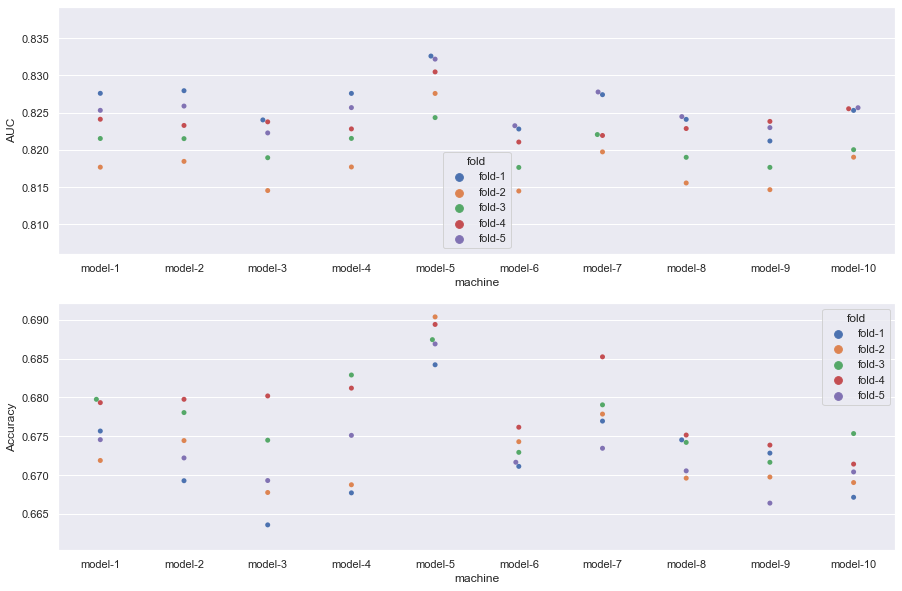

In [28]:
plot_results(toplot_result)

In [29]:
parameters_df[parameters_df.Machine == 'machine-5']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
4,machine-5,250,37,20,8,1.0,0.6


#### Section 1: Gradient Boosting

In [30]:
my_gbc_models = list()
number_of_machines = 8
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 150, 160, 155, 140, 150, 170, 140, 160],
    'max_depth' : [ 20, 15, 20, 25, 18, 22, 16, 19],        
    'learning_rate' : [ 0.005, 0.0055, 0.006, 0.0045, 0.0045, 0.006, 0.0055, 0.0047], 
    'min_samples_leaf': [ 6, 10, 8, 7, 4, 4, 8, 6],
 'rate_aug': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'sample_aug': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    learning_rate_param = parameters['learning_rate'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_gbc = GradientBoostingClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   learning_rate = learning_rate_param, min_samples_leaf = min_samples_leaf_param)
    my_gbc_models.append(my_gbc)

parameters_df = pd.DataFrame(parameters)  

In [31]:
result_tunning = model_fitting_kfold(models = my_gbc_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_dataset_encode,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6
done machine 7
done machine 8


In [32]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

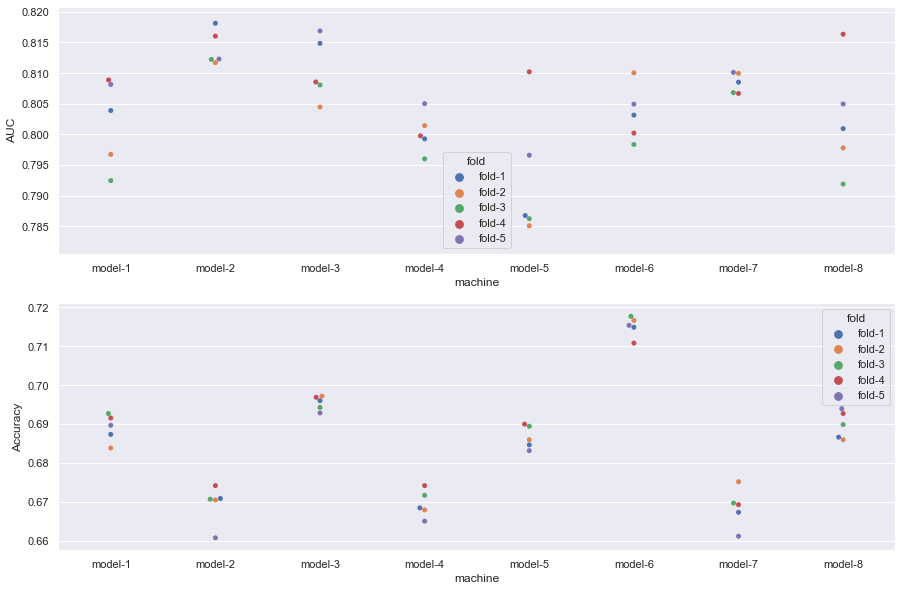

In [33]:
plot_results(toplot_result)

In [34]:
parameters_df[parameters_df.Machine == 'machine-2']

,Machine,n_estimators,max_depth,learning_rate,min_samples_leaf,rate_aug,sample_aug
1,machine-2,160,15,0.0055,10,1.0,0.5


<b> Seems that the RF is the best

### Fast Training

#### Section 1: Random Forest

In [35]:
my_rf_models = list()
number_of_machines = 1
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [250],
    'max_depth' : [37],        
    'min_samples_split' : [20], 
    'min_samples_leaf': [8],
 'rate_aug': [1.0],
 'sample_aug': [0.6] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [37]:
result_tunning, modelsTrained_rf = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_dataset_encode,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 1)

done machine 1


In [40]:
weight_data = train_dataset_encode[train_dataset_encode.target.isin([0,1])]

In [43]:
weighted_model_RF = weighting_models(models = modelsTrained_rf , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_rf , features = features_to_use, data = weight_data, trained_model = weighted_model_RF)

In [44]:
roc_auc_score(weight_data.target.values,result)

0.9008305819763966

#### Section 1: Gradient Boosting

In [45]:
my_gbc_models = list()
number_of_machines = 1
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [160],
    'max_depth' : [ 15],        
    'learning_rate' : [ 0.0055], 
    'min_samples_leaf': [ 10],
 'rate_aug': [1.0],
 'sample_aug': [0.5] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    learning_rate_param = parameters['learning_rate'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_gbc = GradientBoostingClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   learning_rate = learning_rate_param, min_samples_leaf = min_samples_leaf_param)
    my_gbc_models.append(my_gbc)

parameters_df = pd.DataFrame(parameters)  

In [46]:
result_tunning, modelsTrained_gbm = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_dataset_encode,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 1)

done machine 1


In [47]:
weighted_model_GBM = weighting_models(models = modelsTrained_gbm , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_gbm , features = features_to_use, data = weight_data, trained_model = weighted_model_GBM )

In [48]:
roc_auc_score(weight_data.target.values,result)

0.8837852023655433

----

<b> The winner is the RF

## Final Training

### Testing on validation

bagging and consolidation with logistic regression

In [76]:
validation_dataset = validation_dataset[ ['target'] + numerical_features]
validation_dataset_distance = compute_mahalanobis_parts(validation_dataset, numerical_features, 20000,[True,True], means_train, cov_train )
validation_dataset_scaled = scaler(validation_dataset_distance, scalerx)

In [79]:
validation_dataset_encode = count_encoding(validation_dataset_distance, labels_counting, numerical_features)

In [80]:
validation_dataset_encode

,target,var_0,var_1,var_2,var_6,var_12,var_13,var_21,var_22,var_26,...,countvar_133,countvar_139,countvar_146,countvar_148,countvar_164,countvar_165,countvar_166,countvar_174,countvar_190,countvar_198
0,1,8.5348,-3.5813,13.0959,4.7645,13.7374,16.0926,16.8552,3.4326,1.4043,...,1178,1099,1839,358,1629,2434,1897,1623,1375,1382
1,0,10.3605,-4.3507,7.8358,4.3219,13.8975,8.4832,13.0665,4.1745,-5.9777,...,1754,1763,1759,1919,1770,1413,1867,272,1744,1471
2,0,11.3370,4.0412,9.8642,5.5807,13.9880,4.0192,25.6389,5.3746,-4.6260,...,1613,1553,486,1751,696,1514,1725,1936,1744,1382
3,0,14.9643,-1.9210,13.0060,4.3073,14.2198,-0.7442,10.5602,6.2261,-11.0322,...,1323,1478,258,1919,453,2042,1533,1936,1893,1143
4,0,7.2640,6.7137,9.2704,6.2205,14.1547,12.1726,18.4764,6.1235,-13.1055,...,840,1763,1983,364,1268,1790,555,1936,1194,1143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,14.0167,-1.3589,8.1386,6.0607,13.8895,3.4458,7.3982,4.1840,-14.0247,...,1754,1568,1983,1632,1653,133,1533,1879,1700,1991
49996,1,13.9505,-4.4078,9.9561,5.7723,13.8907,15.4165,0.4764,6.2318,-5.5729,...,1851,1884,1759,1751,1268,1790,1867,1879,1893,1976
49997,0,6.9651,-0.8610,8.1860,5.6770,14.0536,14.2000,19.7629,2.8078,-2.8443,...,1613,672,1759,1943,1561,2042,1867,739,1455,1976
49998,0,11.7294,0.2088,10.9457,4.8186,14.1581,8.7693,8.1183,6.4082,-6.3577,...,1495,312,910,1322,1653,1514,1867,1758,561,1976


In [81]:
predictions_val = weighting_models(models = modelsTrained_rf , features = features_to_use, data = validation_dataset_encode, trained_model = weighted_model_RF)
vector_predictions = np.concatenate((predictions_val), axis=None)

In [82]:
roc_auc_score(target_vector, vector_predictions)

0.8569669629934055

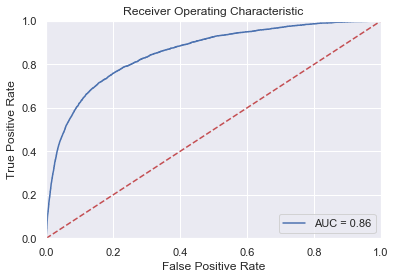

In [83]:
fpr, tpr, threshold = roc_curve(target_vector, vector_predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [84]:
result_validation = reconstructing_data([validation_dataset_encode], [predictions_val])

In [85]:
result_validation.head()

,target,var_0,var_1,var_2,var_6,var_12,var_13,var_21,var_22,var_26,...,countvar_133,countvar_139,countvar_146,countvar_148,countvar_164,countvar_165,countvar_166,countvar_174,countvar_190,countvar_198
0,1,8.5348,-3.5813,13.0959,4.7645,13.7374,16.0926,16.8552,3.4326,1.4043,...,1178,1099,1839,358,1629,2434,1897,1623,1375,1382
1,0,10.3605,-4.3507,7.8358,4.3219,13.8975,8.4832,13.0665,4.1745,-5.9777,...,1754,1763,1759,1919,1770,1413,1867,272,1744,1471
2,0,11.3370,4.0412,9.8642,5.5807,13.9880,4.0192,25.6389,5.3746,-4.6260,...,1613,1553,486,1751,696,1514,1725,1936,1744,1382
3,0,14.9643,-1.9210,13.0060,4.3073,14.2198,-0.7442,10.5602,6.2261,-11.0322,...,1323,1478,258,1919,453,2042,1533,1936,1893,1143
4,0,7.2640,6.7137,9.2704,6.2205,14.1547,12.1726,18.4764,6.1235,-13.1055,...,840,1763,1983,364,1268,1790,555,1936,1194,1143


### Prediction

In [58]:
test_target = test.assign(target = 0)
test_dataset = test_target[ ['target'] + numerical_features].copy()
test_dataset_distance = compute_mahalanobis_parts(test_dataset, numerical_features, 20000,[True,True], means_train, cov_train )
test_dataset_scaled = scaler(test_dataset_distance, scalerx)

In [86]:
test_dataset_encode = count_encoding(test_dataset_distance, labels_counting, numerical_features)

In [87]:
predictions_test = weighting_models(models = modelsTrained_rf , features = features_to_use, data = test_dataset_encode, trained_model = weighted_model_RF)
vector_predictions = np.concatenate((predictions_test), axis=None)

In [88]:
vector_predictions

array([0.09492673, 0.04233828, 0.18622923, ..., 0.00961682, 0.16706514,
       0.09840094])

In [89]:
vector_predictions.shape

(200000,)

In [93]:
test['target'] = vector_predictions
test['target'] = np.where(test['target'] >0.07, 1, 0) ## they are not probas take care

In [94]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,1
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,0
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,1
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,0
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,0


### Saving Results

In [95]:
gatito
test[['ID_code','target']].set_index('ID_code').to_csv('my_prediction.csv')